In [2]:
import pandas as pd

# Load cleaned data
df = pd.read_csv('data/cleaned_sessions.csv')

# Quick peek
df.head()

,fullvisitorid,visitid,visitnumber,date,devicecategory,country,source,pageviews,timeonsite,transactions,transactionrevenue,converted,revenue,funnel_stage
0,7007041817691781124,1499201738,1,2017-07-04,desktop,United States,google,11.0,452.0,NaN,NaN,0,0.0,Deep Engagement
1,7167584606601664694,1499233841,1,2017-07-04,tablet,United States,(direct),15.0,1448.0,NaN,NaN,0,0.0,Deep Engagement
2,1626564234331086419,1499219717,1,2017-07-04,desktop,Taiwan,yahoo,13.0,785.0,NaN,NaN,0,0.0,Deep Engagement
3,5441957633456467994,1499151247,7,2017-07-04,desktop,United States,(direct),14.0,304.0,NaN,NaN,0,0.0,Deep Engagement
4,1687787026115328109,1499186518,1,2017-07-04,mobile,Canada,google,15.0,163.0,NaN,NaN,0,0.0,Deep Engagement


In [4]:
# Count of sessions per funnel stage
stage_counts = df['funnel_stage'].value_counts().sort_index()

# Conversion rate by funnel stage
conversion_by_stage = df.groupby('funnel_stage')['converted'].mean().sort_index() * 100

# Combine into one DataFrame for easy viewing
funnel_summary = pd.DataFrame({
    'Sessions': stage_counts,
    'Conversion Rate (%)': conversion_by_stage.round(2)
})

funnel_summary

,Sessions,Conversion Rate (%)
funnel_stage,,
Bounced,3,0.00
Browsed,8277,0.01
Deep Engagement,682,14.08
Engaged,1038,0.00


In [5]:
# Conversion rate by device
device_summary = df.groupby('devicecategory').agg(
    sessions=('converted', 'count'),
    conversions=('converted', 'sum'),
    conversion_rate=('converted', 'mean')
).sort_values('conversion_rate', ascending=False)

# Format as percentage
device_summary['conversion_rate'] = (device_summary['conversion_rate'] * 100).round(2)

device_summary

,sessions,conversions,conversion_rate
devicecategory,,,
desktop,6111,88,1.44
tablet,452,2,0.44
mobile,3437,7,0.20


In [6]:
source_summary = df.groupby('source').agg(
    sessions=('converted', 'count'),
    conversions=('converted', 'sum'),
    conversion_rate=('converted', 'mean')
).sort_values('conversion_rate', ascending=False)

source_summary['conversion_rate'] = (source_summary['conversion_rate'] * 100).round(2)

source_summary.head(10)  # Only show top 10 sources

,sessions,conversions,conversion_rate
source,,,
calendar.google.com,2,1,50.00
outlook.live.com,4,1,25.00
dfa,36,1,2.78
(direct),3838,72,1.88
google,3936,21,0.53
Partners,284,1,0.35
m.youtube.com,11,0,0.00
mail.google.com,5,0,0.00
online-metrics.com,1,0,0.00


In [7]:
country_summary = df.groupby('country').agg(
    sessions=('converted', 'count'),
    conversions=('converted', 'sum'),
    conversion_rate=('converted', 'mean')
).sort_values('conversion_rate', ascending=False)

country_summary['conversion_rate'] = (country_summary['conversion_rate'] * 100).round(2)

country_summary.head(10)  # Show top 10 converting countries

,sessions,conversions,conversion_rate
country,,,
United States,4136,95,2.30
Israel,60,1,1.67
Canada,308,1,0.32
(not set),7,0,0.00
Nepal,2,0,0.00
Netherlands,139,0,0.00
New Zealand,45,0,0.00
Nicaragua,4,0,0.00
Nigeria,19,0,0.00


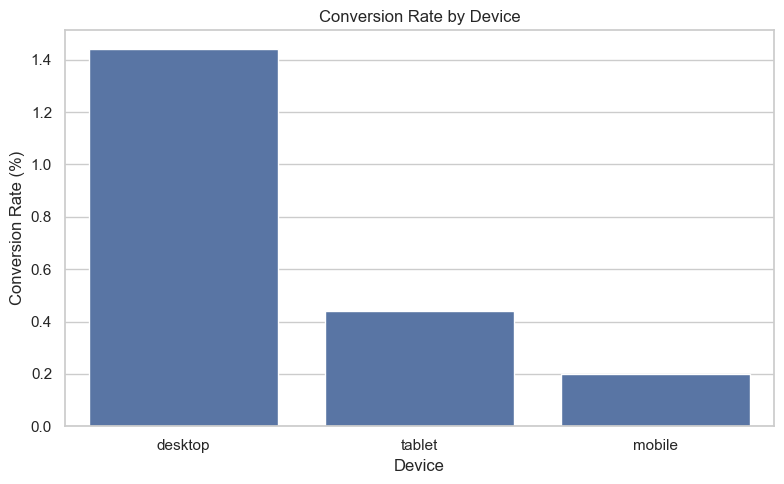

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=device_summary.index, y=device_summary['conversion_rate'])
plt.title('Conversion Rate by Device')
plt.ylabel('Conversion Rate (%)')
plt.xlabel('Device')
plt.tight_layout()
plt.show()

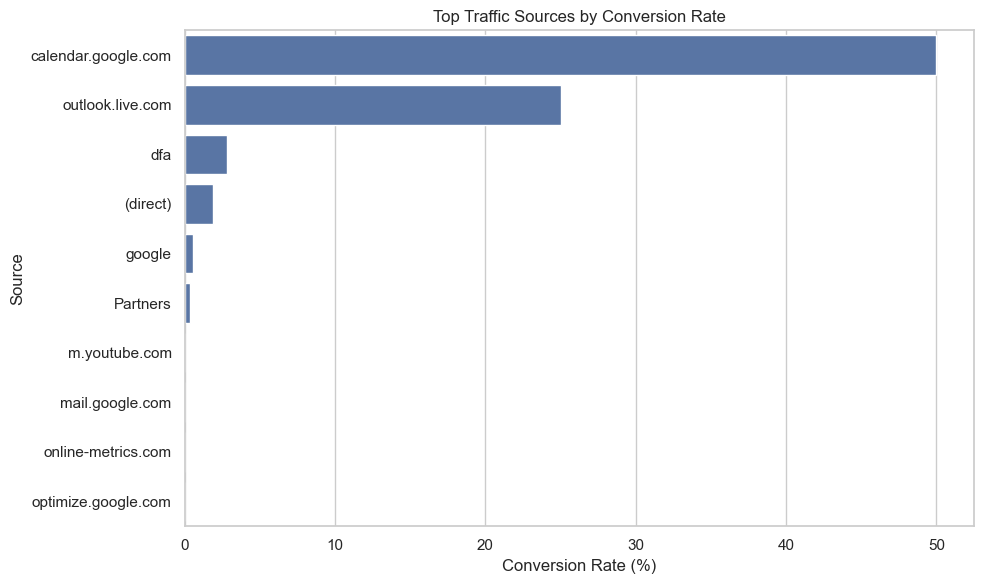

In [9]:
top_sources = source_summary.head(10).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=top_sources, x='conversion_rate', y='source')
plt.title('Top Traffic Sources by Conversion Rate')
plt.xlabel('Conversion Rate (%)')
plt.ylabel('Source')
plt.tight_layout()
plt.show()

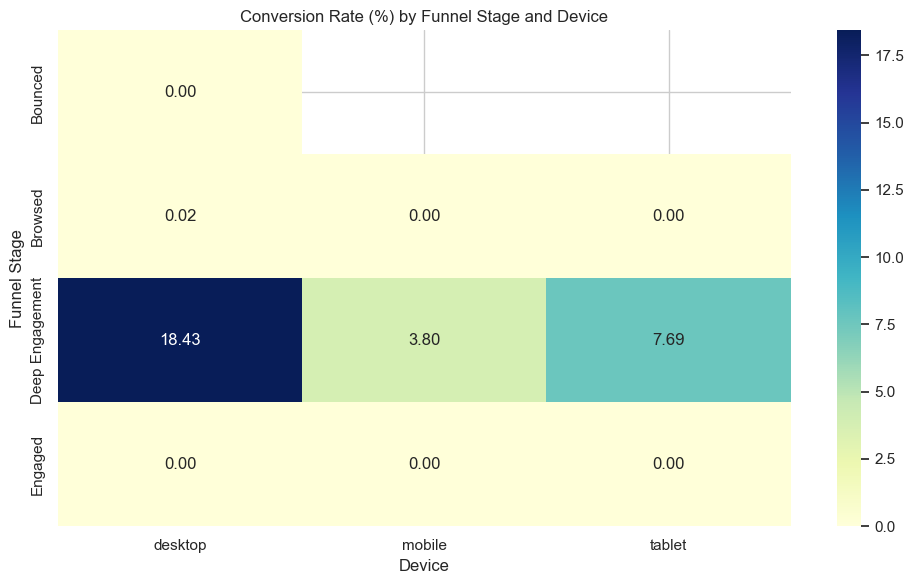

In [10]:
heatmap_data = df.groupby(['funnel_stage', 'devicecategory'])['converted'].mean().unstack() * 100

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data.round(2), annot=True, fmt=".2f", cmap='YlGnBu')
plt.title('Conversion Rate (%) by Funnel Stage and Device')
plt.ylabel('Funnel Stage')
plt.xlabel('Device')
plt.tight_layout()
plt.show()

In [11]:
# Scorecard by device + funnel stage
scorecard = df.groupby(['devicecategory', 'funnel_stage']).agg(
    sessions=('converted', 'count'),
    conversions=('converted', 'sum'),
    conversion_rate=('converted', 'mean')
).reset_index()

# Add a "leak risk" flag: high engagement, low conversion
scorecard['leak_risk'] = scorecard.apply(
    lambda row: '⚠️ Silent Leak' if row['funnel_stage'] in ['Engaged', 'Deep Engagement'] and row['conversion_rate'] < 0.01 else '',
    axis=1
)

# Convert rate to percentage
scorecard['conversion_rate'] = (scorecard['conversion_rate'] * 100).round(2)

scorecard.sort_values(by='sessions', ascending=False).head(10)

,devicecategory,funnel_stage,sessions,conversions,conversion_rate,leak_risk
1,desktop,Browsed,4950,1,0.02,
4,mobile,Browsed,2948,0,0.00,
3,desktop,Engaged,686,0,0.00,⚠️ Silent Leak
2,desktop,Deep Engagement,472,87,18.43,
7,tablet,Browsed,379,0,0.00,
6,mobile,Engaged,305,0,0.00,⚠️ Silent Leak
5,mobile,Deep Engagement,184,7,3.80,
9,tablet,Engaged,47,0,0.00,⚠️ Silent Leak
8,tablet,Deep Engagement,26,2,7.69,
0,desktop,Bounced,3,0,0.00,


In [12]:
# Filter for segments that are high engagement + low conversion
leaks = scorecard[
    (scorecard['funnel_stage'].isin(['Engaged', 'Deep Engagement'])) &
    (scorecard['conversion_rate'] < 1.0)
]

leaks.sort_values(by='sessions', ascending=False)

,devicecategory,funnel_stage,sessions,conversions,conversion_rate,leak_risk
3,desktop,Engaged,686,0,0.0,⚠️ Silent Leak
6,mobile,Engaged,305,0,0.0,⚠️ Silent Leak
9,tablet,Engaged,47,0,0.0,⚠️ Silent Leak
